In [1]:
!chmod 600 /content/kaggle.json

In [2]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d emmanuelfwerr/london-weather-data

  0% 0.00/226k [00:00<?, ?B/s]
100% 226k/226k [00:00<00:00, 23.2MB/s]


In [3]:
import zipfile
zip_file = zipfile.ZipFile('/content/london-weather-data.zip')
zip_file.extractall('/tmp/')

In [4]:
import pandas as pd

df_train = pd.read_csv('/tmp/london_weather.csv')
df_train.head(10)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
5,19790106,5.0,3.8,39.0,8.3,-0.5,-6.6,0.7,102780.0,1.0
6,19790107,8.0,0.0,13.0,8.5,1.5,-5.3,5.2,102520.0,0.0
7,19790108,8.0,0.1,15.0,5.8,6.9,5.3,0.8,101870.0,0.0
8,19790109,4.0,5.8,50.0,5.2,3.7,1.6,7.2,101170.0,0.0
9,19790110,7.0,1.9,30.0,4.9,3.3,1.4,2.1,98700.0,0.0


In [5]:
df_train.shape

(15341, 10)

In [6]:
df_train.info

<bound method DataFrame.info of            date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0      19790101          2.0       7.0              52.0       2.3       -4.1   
1      19790102          6.0       1.7              27.0       1.6       -2.6   
2      19790103          5.0       0.0              13.0       1.3       -2.8   
3      19790104          8.0       0.0              13.0      -0.3       -2.6   
4      19790105          6.0       2.0              29.0       5.6       -0.8   
...         ...          ...       ...               ...       ...        ...   
15336  20201227          1.0       0.9              32.0       7.5        7.5   
15337  20201228          7.0       3.7              38.0       3.6        1.1   
15338  20201229          7.0       0.0              21.0       4.1        2.6   
15339  20201230          6.0       0.4              22.0       5.6        2.7   
15340  20201231          7.0       1.3              34.0       1.5       -0.8

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM

In [8]:
df_train.isnull().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [9]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['date'].head()
df_train['mean_temp'].fillna(df_train['mean_temp'].mean(), inplace = True)
df_train = df_train[['date', 'mean_temp']]

df_train.head()

,date,mean_temp
0,1970-01-01 00:00:00.019790101,-4.1
1,1970-01-01 00:00:00.019790102,-2.6
2,1970-01-01 00:00:00.019790103,-2.8
3,1970-01-01 00:00:00.019790104,-2.6
4,1970-01-01 00:00:00.019790105,-0.8


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       15341 non-null  datetime64[ns]
 1   mean_temp  15341 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 239.8 KB


In [11]:
london = df_train[['date', 'mean_temp']].copy()
london['only_date'] = london['date'].dt.date

london_final = london.drop('date', axis = 1)
london_final.set_index('only_date', inplace = True)
london_final.head()

,mean_temp
only_date,
1970-01-01,-4.1
1970-01-01,-2.6
1970-01-01,-2.8
1970-01-01,-2.6
1970-01-01,-0.8


In [12]:
london_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15341 entries, 1970-01-01 to 1970-01-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean_temp  15341 non-null  float64
dtypes: float64(1)
memory usage: 239.7+ KB


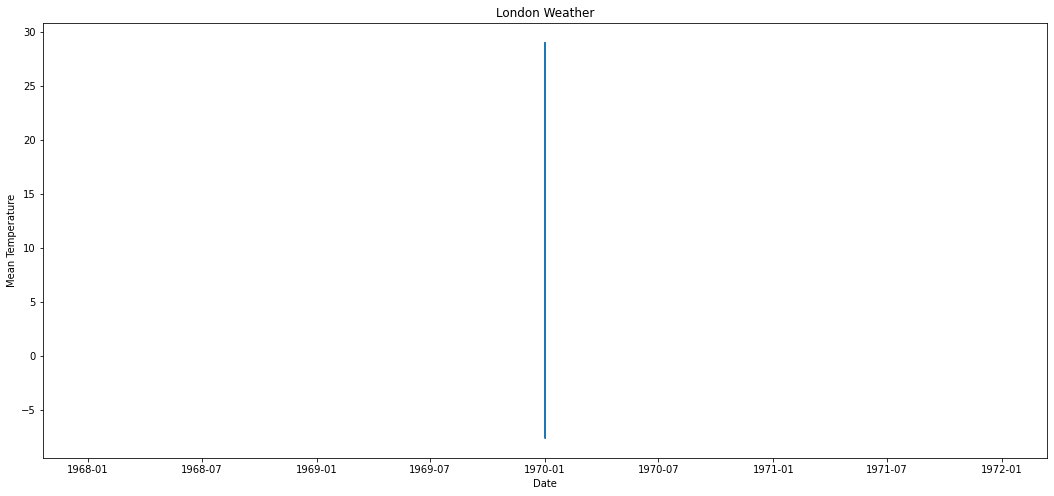

In [13]:
plt.figure(figsize = (18, 8))
plt.plot(london_final)
plt.title('London Weather')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.show()

In [14]:
date_values = df_train['date'].values
temperature_values = df_train['mean_temp'].values

In [15]:
def windowed_dataset(series, window_size, batch_size,shuffle_buffer):
  series = tf.expand_dims(series, axis = 1)
  data_set = tf.data.Dataset.from_tensor_slices(series)
  data_set = data_set.window(window_size + 1, shift = 1, drop_remainder = True)
  data_set = data_set.flat_map(lambda w: w.batch(window_size + 1))
  data_set = data_set.shuffle(shuffle_buffer)
  data_set = data_set.map(lambda w: (w[:-1], w[-1:]))
  return data_set.batch(batch_size).prefetch(1)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(temperature_values, date_values, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

12272 3069


In [17]:
data_x_train = windowed_dataset(x_train, window_size=60, batch_size=30, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=30, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [18]:
max = df_train['mean_temp'].max()
min = df_train['mean_temp'].min()
mae_x = (max - min) * 0.1
print(mae_x)

3.66


In [21]:
# callback
class historyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < mae_x):
      self.model.stop_training = True
      print("\n value of MAE is less than < 10% of data scale and forced to stop")
callbacks = historyCallback()

In [22]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train,
                    epochs = 200,
                    validation_data = data_x_test,
                    callbacks=[callbacks])

Epoch 1/200
408/408 [==============================] - 57s 120ms/step - loss: 5.1515 - mae: 5.6325 - val_loss: 4.3755 - val_mae: 4.8541
Epoch 2/200
408/408 [==============================] - 35s 83ms/step - loss: 4.2507 - mae: 4.7285 - val_loss: 4.2643 - val_mae: 4.7421
Epoch 3/200
408/408 [==============================] - 34s 83ms/step - loss: 4.1534 - mae: 4.6305 - val_loss: 4.1856 - val_mae: 4.6631
Epoch 4/200
408/408 [==============================] - 35s 84ms/step - loss: 4.0694 - mae: 4.5462 - val_loss: 4.0739 - val_mae: 4.5508
Epoch 5/200
408/408 [==============================] - 36s 85ms/step - loss: 3.9896 - mae: 4.4660 - val_loss: 3.9892 - val_mae: 4.4657
Epoch 6/200
408/408 [==============================] - 34s 81ms/step - loss: 3.8984 - mae: 4.3744 - val_loss: 3.8799 - val_mae: 4.3559
Epoch 7/200
408/408 [==============================] - 34s 81ms/step - loss: 3.7912 - mae: 4.2661 - val_loss: 3.7615 - val_mae: 4.2363
Epoch 8/200
408/408 [==============================] -

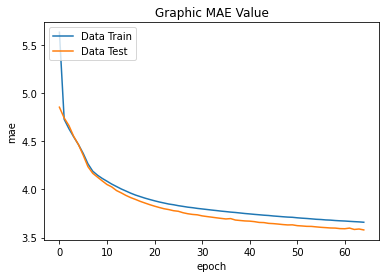

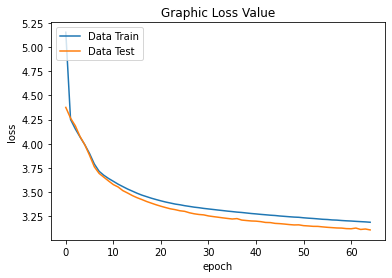

In [23]:
# Graphic Plot of MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Graphic MAE Value')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['Data Train', 'Data Test'], loc='upper left')
plt.show()


# Graphic Plot of LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Graphic Loss Value')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Data Train', 'Data Test'], loc='upper left')
plt.show()